In [ ]:
# built-in modules

# 3-rd party modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# local modules
import fluxprint

In [2]:
url = 'https://citydata.icos-cp.eu/licence_accept?ids=%5B%22F8xViMt9DnfYx7wFSfU-BsRS%22%5D'
icos_cities_ffp = fluxprint.io.read_from_url(url)
icos_cities_ffp.footprint.attrs['convention_order'] = '(lon,lat)'
            

Failed to read url as csv: File is not a zip file


In [3]:
url = 'https://citydata.icos-cp.eu/licence_accept?ids=%5B%22bSV20lxhTszQobvLFm0KlCeU%22%5D'
icos_cities_data = fluxprint.io.read_from_url(url, na_values=['-9999'])
icos_cities_data['TIMESTAMP'] = pd.to_datetime(
    icos_cities_data.TIMESTAMP_START.astype(str)) - pd.Timedelta('1h')
icos_cities_data = icos_cities_data[np.isin(icos_cities_data.TIMESTAMP.dt.strftime('%y%m%d%H%M'),
                         icos_cities_ffp.timestep.astype(str))]
# icos_cities_data = icos_cities_data.head(10)

In [4]:
crs = fluxprint.rasterio.crs.CRS.from_string('EPSG:3035')
fluxprint_ffp = fluxprint.wrapper(
    data=icos_cities_data,
    # query='TIMESTAMP_START.astype("str").str.startswith("202404241300")',
    by='TIMESTAMP',
    out_as='nc', precision=10,
    # model=fluxprint.model.hsieh2000,
    meta=dict(
        Tower_Location_Latitude=48.88514,
        Tower_Location_Longitude=2.42222,
        Tower_Location_CRS="EPSG:4326",
        timestep={'timezone': 'UTC'},
        Coordinate_Reference_System=crs.to_string(),
        crs_projection4=crs.to_proj4(),
        crs_wkt=crs.to_wkt()),
    domain= [-1500, 1500, -1500, 1500],
    # dst='sample/output/paris_ffp_202506061619.tif',
    zm=102.5 - 7, z0=0.8, pblh=500, verbosity=0)

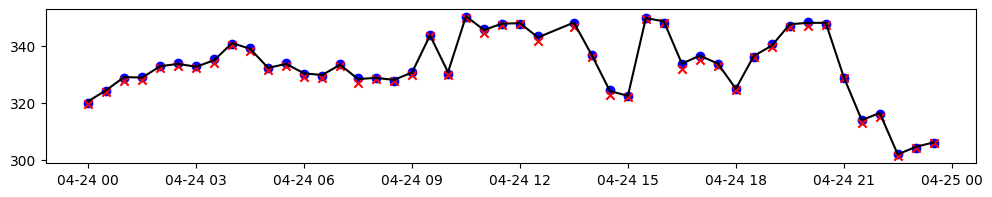

In [ ]:
def find_angle(point, middle):
    dx = point[0] - middle[0]
    dy = point[1] - middle[1]

    # Compute angle from x-axis (counter-clockwise), then convert:
    angle_rad = np.arctan2(dx, dy)
    angle_deg = np.degrees(angle_rad)

    # Convert to compass angle: 0° = North, increasing clockwise
    compass_angle = (90 - angle_deg) % 360
    return compass_angle

plt.figure(figsize=(12, 2))
plt.plot(icos_cities_data['TIMESTAMP'], icos_cities_data.WD, c='k')
plt.scatter(fluxprint_ffp.timestep,
    [find_angle(fluxprint.utils.find_peak(f), (150, 150))
     for f in fluxprint_ffp.footprint[:, :, :]], marker='o', c='blue')
plt.scatter(
    pd.to_datetime(icos_cities_ffp.timestep, format='%y%m%d%H%M'),
    [find_angle(fluxprint.utils.find_peak(f), (800, 800))
     for f in icos_cities_ffp.footprint[:, :, :]], marker='x', c='red')
plt.show()


c:\Users\phherigcoimb\Anaconda3\envs\fpaddon\Lib\site-packages\fluxprint\utils.py:292: UserWarning: Convention `(lon,lat)` differs from infered convention `(lat,lon)`.
  warnings.warn(



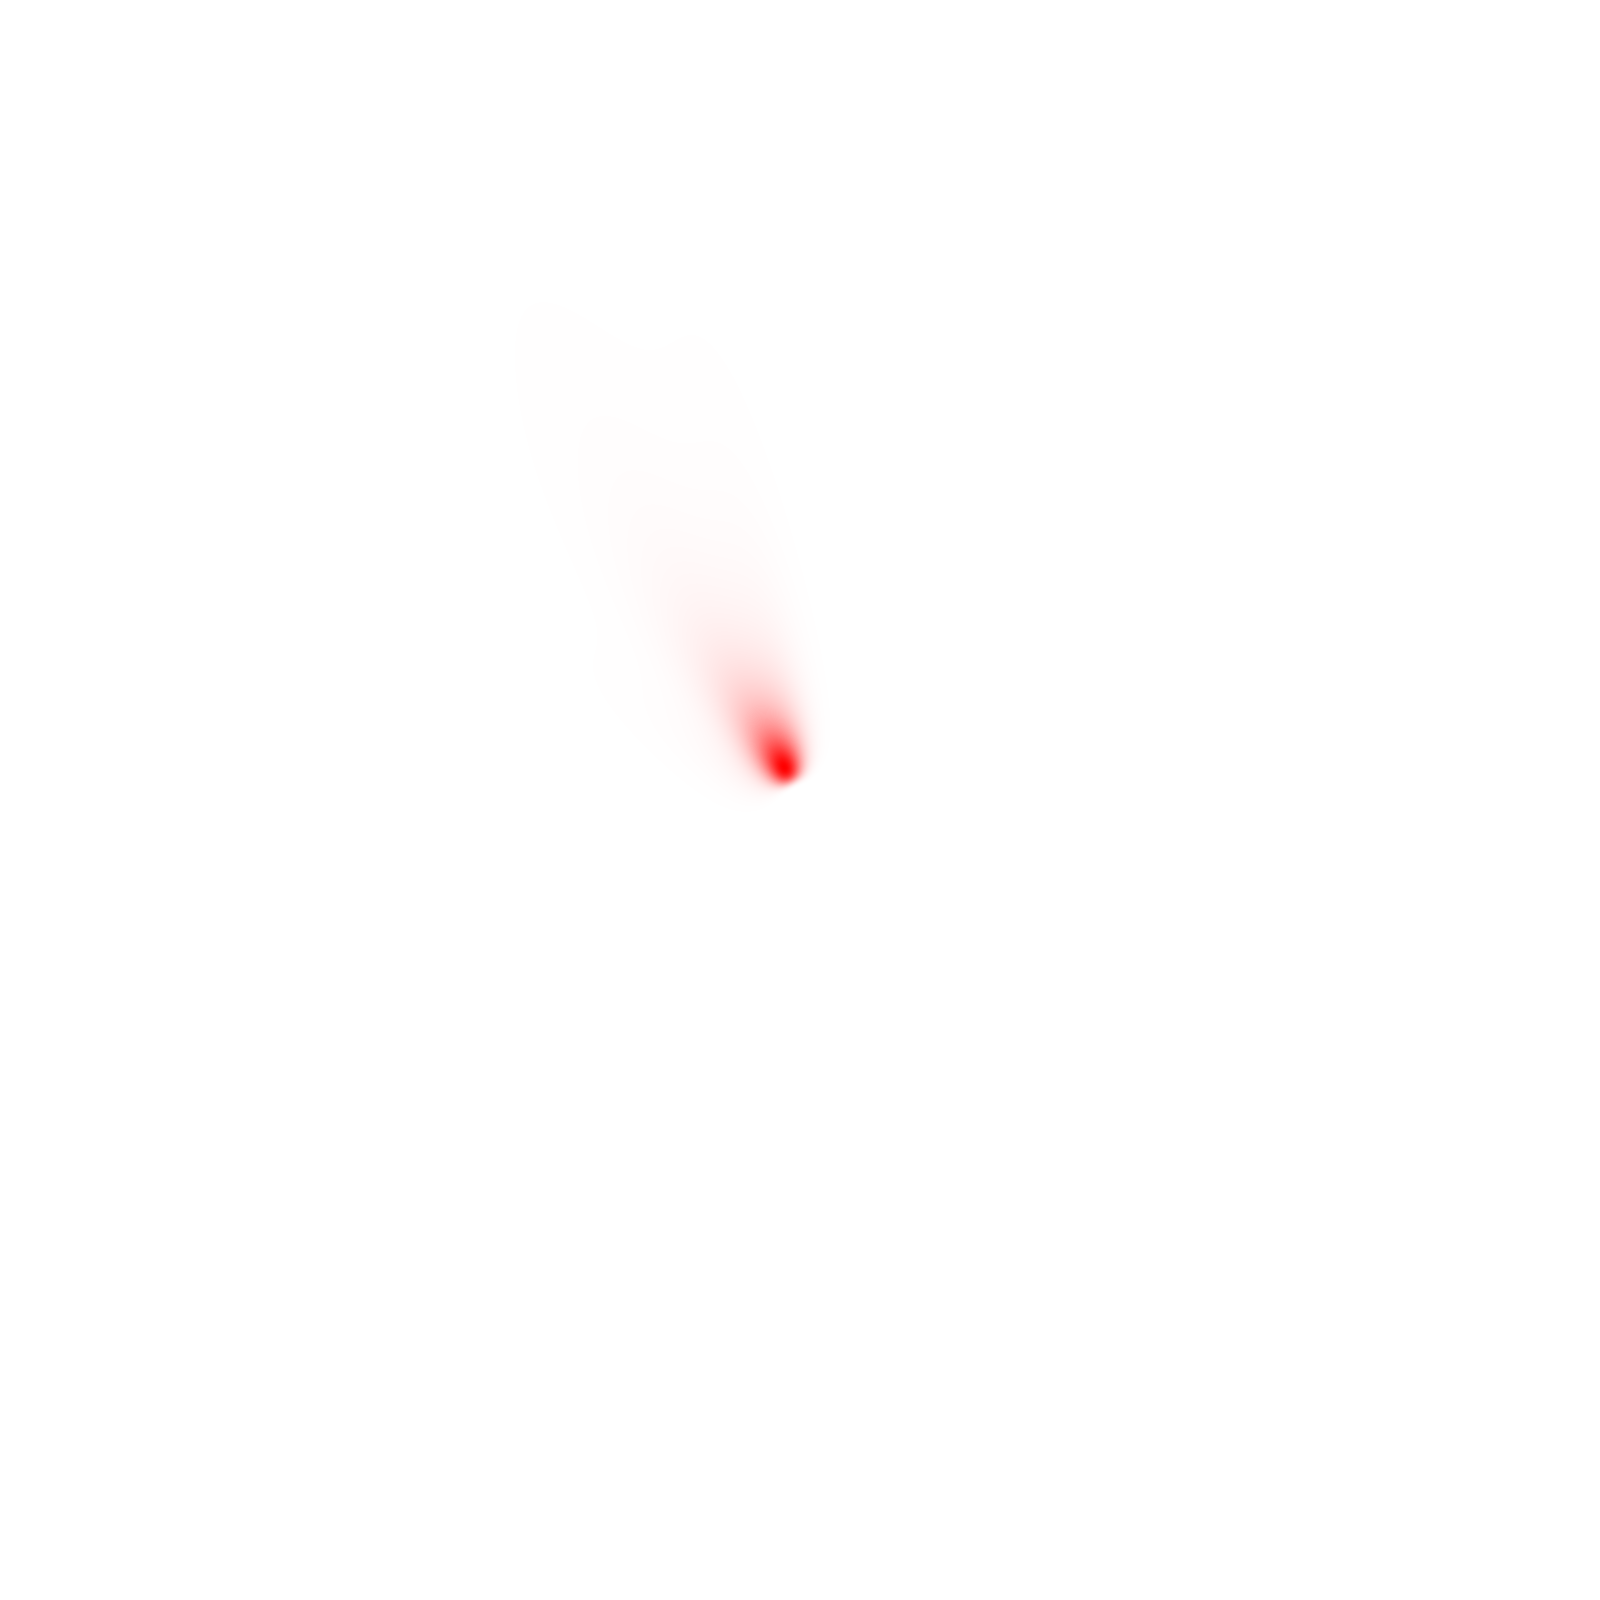
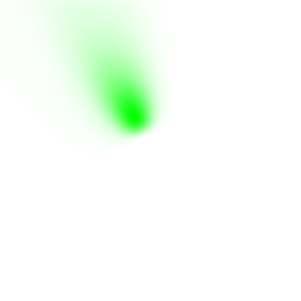

In [6]:
fluxprint.utils.plot_leaflet(icos_cities_ffp, fluxprint_ffp, labels=[
                             'ICOS Cities Product', 'FluxPrint'])